# Bay Area Bike Share Trips - Data Analysis Using Google BigQuery

### Author: Colby Carter
### Date: 6/18/2018

## Purpose

Through this exercise, we seek to analyze the publicly available Bay Area Bike Share data by accessing Google's BigQuery from the command line. Specifically, we explore the most popular trips that could be called _commuter trips_ and recommend which types of passes would appear to attract the most ridership.

## Summarize Bike Share Trips Dataset

There are three public bike share datasets: one on the _trips_ themselves, including start and end location and time information; one with key bike _station_ information, such as number of bike docks; and one with time-stamped snapshots of station _status_ and bike availability. For our questions, we will focus on the trips data, with a confirmation of docking status at popular stations.

In [1]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

We first look at the top of the trips dataset. The schema includes a unique identifier for each trip, a start and end station location and timestamp, a duration of the trip in seconds, the number of the bike used, and limited information on the customer.

In [59]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT * 
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  LIMIT 5' > result.csv

Waiting on bqjob_r7d4f885923dcc92f_0000016406bd1160_1 ... (0s) Current status: DONE   

In [60]:
top_5 = pd.read_csv('result.csv')
top_5

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00,Mezes,83,2015-09-24 18:06:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00,Mezes,83,2015-10-25 19:51:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00,Mezes,83,2015-10-25 19:51:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00,Mezes,83,2016-03-18 12:14:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00,Mezes,83,2015-12-06 12:28:00,Mezes,83,44,94064,Customer


These data include **983,648 trips** over a three year period from August 29, 2013 through August 31, 2016.

In [3]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT count(*) as Total_trips 
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`'


Total_trips
983648


Waiting on bqjob_r704d9d455b1b6664_0000016411100e1d_1 ... (0s) Current status: DONE   

In [4]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT min(start_date) AS first_trip, max(end_date) AS last_return 
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > result.csv

Waiting on bqjob_r509bc526f7efd113_000001640feb1638_1 ... (0s) Current status: DONE   

In [5]:
period = pd.read_csv('result.csv')
period

,first_trip,last_return
0,2013-08-29 09:08:00,2016-08-31 23:48:00


We see that there are **84** distinct bike station locations across the Bay Area, and already we see evidence that bike-share users overwhelmingly prefer longer-term passes to one-off rides, with 86% of trips taken by subscribers (customers with 1-month or annual passes), not one-time trip purchases. 

In [2]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT count(distinct start_station_name) as Stations
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`'


Stations
84


Waiting on bqjob_r11af572cc628a094_00000164110fefe8_1 ... (0s) Current status: DONE   

In [35]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT subscriber_type, count(*) as count
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY 1' > result.csv

Waiting on bqjob_r21125a9ccb87c711_000001640e31f596_1 ... (0s) Current status: DONE   

In [36]:
customers = pd.read_csv('result.csv')
customers

,subscriber_type,count
0,Customer,136809
1,Subscriber,846839


## Timing of Trips

Knowing the number of trips and types of customers, span of the data, and a sense of the geography, we now look to the timing of trips for more evidence of commuter trips and preferences of the customer base. Dividing the dataset into trips started before versus after noon, we see a fairly close balance, with about 42% of trips made in the morning.

In [55]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT sum(case when EXTRACT(HOUR FROM start_date) < 12 then 1 else 0 end) as morning_trips, 
    sum(case when EXTRACT(HOUR FROM start_date) >= 12 then 1 else 0 end) as afternoon_trips 
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`'  > result.csv

Waiting on bqjob_r32ab02d6ae4bfa95_0000016406bb3133_1 ... (0s) Current status: DONE   

In [56]:
time_of_day = pd.read_csv('result.csv')
time_of_day

,morning_trips,afternoon_trips
0,412339,571309


With a high volume of morning trips, we might expect weekday usage from inbound commutes to exceed weekend usage, with any given weekday yielding roughly three times as many trips as a weekend day. This gives more evidence that much of the customer base is using the service to commute to work.

In [57]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT FORMAT_DATE("%A", DATE(start_date)) AS day_of_week, COUNT(*) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    GROUP BY 1
    ORDER BY 2 desc' > result.csv

Waiting on bqjob_r77adbfe19dba9f11_0000016406bb60ed_1 ... (0s) Current status: DONE   

In [58]:
day_of_week = pd.read_csv('result.csv')
day_of_week

,day_of_week,trips
0,Tuesday,184405
1,Wednesday,180767
2,Thursday,176908
3,Monday,169937
4,Friday,159977
5,Saturday,60279
6,Sunday,51375


We also want to verify whether there is any significant seasonal variation in usage. While there does appear to be a decline of usage in winter months, particularly December, it does not seem so severe to suggest an annual pass would sell poorly.

In [7]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT EXTRACT(month FROM start_date) AS month, COUNT(*) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    GROUP BY 1
    ORDER BY 1' > result.csv

Waiting on bqjob_r62aa2f6d23194196_000001640942ff32_1 ... (0s) Current status: DONE   

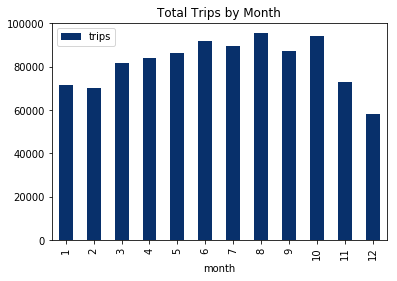

In [18]:
monthly = pd.read_csv('result.csv')
monthly.plot(x="month", y="trips", kind='bar', title="Total Trips by Month", colormap='Blues_r')

Looking more closely at the day of the week and time of day usage, we immediately see the largest contributions coming from peaks around the typical commuting hours of _8am_ and _5pm_. The _8am_ hour alone _during the week_ accounts for over **130,000** trips, or 13% of the data. With two roughly bell-shaped distributions around _8am_ and _5pm_, it is likely that many afternoon rides are return trips--with usage tapering off as the evening goes on.

In [5]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT EXTRACT(hour FROM start_date) AS hour, COUNT(*) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE FORMAT_DATE("%A", DATE(start_date)) NOT in ("Saturday", "Sunday")
    GROUP BY 1
    ORDER BY 1 asc ' > result.csv

Waiting on bqjob_r3a8cd9a70414d4a7_0000016411148da9_1 ... (0s) Current status: DONE   

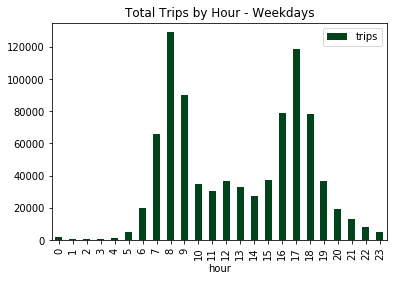

In [6]:
# hour zero is midnight hour
hourly = pd.read_csv('result.csv')
hourly.plot(x="hour", y="trips", kind='bar', title="Total Trips by Hour - Weekdays", colormap='Greens_r', ylim=(0,135000))

As expected, when we isolate weekend usage, we see much lower volume with a more uniform distribution of ride times. These trips are likely made by pay-per-ride customers with higher frequency than those during the week around typical commuting hours.

In [26]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT EXTRACT(hour FROM start_date) AS hour, COUNT(*) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    WHERE FORMAT_DATE("%A", DATE(start_date)) in ("Saturday", "Sunday")
    GROUP BY 1
    ORDER BY 1 asc ' > result.csv

Waiting on bqjob_r63d348c70b1bd080_000001640dbad9e2_1 ... (0s) Current status: DONE   

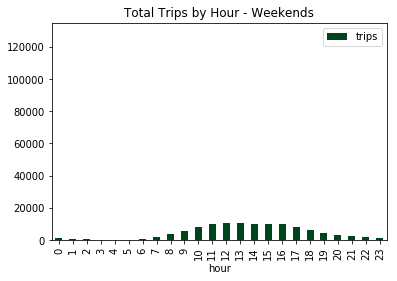

In [28]:
weekends = pd.read_csv('result.csv')
weekends.plot(x="hour", y="trips", kind='bar', title="Total Trips by Hour - Weekends", colormap='Greens_r', ylim=(0,135000))

Lastly for seasonality, we comfirm whether the multimodal distribution of the weekday travel is sustained through the colder winter months. This suggests that many customers are not substituting to alternative transit methods and may be happy with an annual commuter pass.

In [29]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT EXTRACT(hour FROM start_date) AS hour, COUNT(*) AS trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE FORMAT_DATE("%A", DATE(start_date)) NOT in ("Saturday", "Sunday")
        AND EXTRACT(month FROM start_date) in (12, 1, 2)
    GROUP BY 1
    ORDER BY 1 asc ' > result.csv

Waiting on bqjob_r59e88466ce65dcf3_000001640dc3b250_1 ... (2s) Current status: DONE   

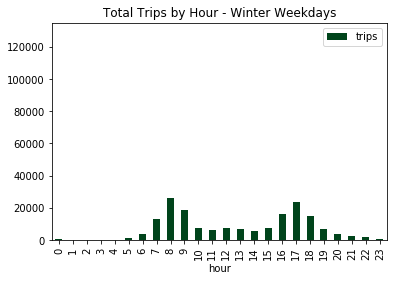

In [30]:
winter = pd.read_csv('result.csv')
winter.plot(x="hour", y="trips", kind='bar', title="Total Trips by Hour - Winter Weekdays", colormap='Greens_r', ylim=(0,135000))

Consistent with these trends, we see that the vast majority of trips are under 25 minutes, which is a reasonable expectation for commuters given the much longer transit alternatives.

In [7]:
%%bash
bq query --use_legacy_sql=FALSE --max_rows=1000000 --format=csv '
SELECT duration_sec / 60.0 as duration_min
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE duration_sec < 6000' > result.csv

Waiting on bqjob_r479918bddcb1d16d_000001641117dc08_1 ... (2s) Current status: DONE   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f67d58d68>]],
      dtype=object)

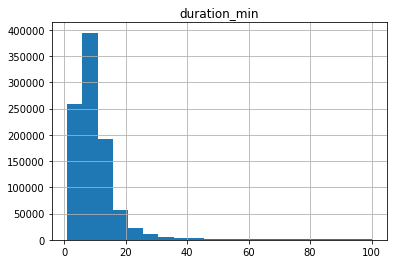

In [8]:
times = pd.read_csv('result.csv')
times.hist(bins=20)

## Geography of Trips

With strong evidence that much of the customer base is using the bike share system for weekday commutes, we look to identify which station-to-station trips, as well as round trips, are driving usage, with a check of whether there are enough bikes available at these locations on average.

The top ten departure stations alone (out of 84 total stations) account for over 430,000 trips, or nearly half. They also mostly concentrate around a few key areas: _San Francisco Caltrain, Harry Bridges Plaza, Townsend, Market_, and _Sansome_ streets.

In [41]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT start_station_name, count(*) as trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY 1
    ORDER BY 2 desc LIMIT 10' > result.csv

Waiting on bqjob_r6eac7c6b8b41b603_0000016409d8e608_1 ... (0s) Current status: DONE   

In [42]:
starts = pd.read_csv('result.csv')
starts.head(10)

,start_station_name,trips
0,San Francisco Caltrain (Townsend at 4th),72683
1,San Francisco Caltrain 2 (330 Townsend),56100
2,Harry Bridges Plaza (Ferry Building),49062
3,Embarcadero at Sansome,41137
4,2nd at Townsend,39936
5,Temporary Transbay Terminal (Howard at Beale),39200
6,Steuart at Market,38531
7,Market at Sansome,35142
8,Townsend at 7th,34894
9,Market at 10th,30209


In [47]:
# total trips by top 10 start stations
sum(starts["trips"])

436894

The list of top destination stations and their trip frequencies look almost identical to those of departure stations, again giving evidence that a significant portion of these rides are parts of round-trip commutes. And similarly, the top ten arrival stations make up nearly half of all trips in the data.

In [67]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT end_station_name, count(*) as trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY 1
    ORDER BY 2 desc LIMIT 10' > result.csv

Waiting on bqjob_r5bd64fe5464bca86_000001640e7e3dc1_1 ... (0s) Current status: DONE   

In [68]:
ends = pd.read_csv('result.csv')
ends.head(10)

,end_station_name,trips
0,San Francisco Caltrain (Townsend at 4th),92014
1,San Francisco Caltrain 2 (330 Townsend),58713
2,Harry Bridges Plaza (Ferry Building),50185
3,Embarcadero at Sansome,46197
4,2nd at Townsend,44145
5,Market at Sansome,40956
6,Steuart at Market,39598
7,Townsend at 7th,38545
8,Temporary Transbay Terminal (Howard at Beale),35477
9,Market at 4th,26762


In [46]:
# total trips by top 10 end stations
sum(ends["trips"])

472592

Top start and end station combinations--or routes--feature many combinations of the above stations, which is to say, the most popular departure stations do not strictly or uniformly lead to trips to just one or two destinations, but rather at least several. For example, _Harry Bridges Plaza (Ferry Building)_--the third most popular departing station--features the most frequent end-to-end route going to _Embarcadero at Sansome_, but this only accounts for 9,000 out of its 49,000 departing trips, or fewer than 20%. The top ten one-way routes make up nearly 70,000 trips, nearly 10% of the total.

We do, however, see contenders for routes in which many riders could be returning to their original station, including _San Francisco Caltrain 2 (330 Townsend) and Townsend at 7th_--up to 6,836 potential round trips.

In [6]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT start_station_name, end_station_name, count(*) as trips
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY start_station_name, end_station_name
    ORDER BY trips desc 
    LIMIT 10' > result.csv

Waiting on bqjob_r2090a513665939a8_000001640ff235d9_1 ... (0s) Current status: DONE   

In [7]:
routes = pd.read_csv('result.csv')
routes.head(10)

,start_station_name,end_station_name,trips
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874
5,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),6836
6,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),6351
7,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),6215
8,Steuart at Market,2nd at Townsend,6039
9,Steuart at Market,San Francisco Caltrain (Townsend at 4th),5959


In [8]:
# total trips by top 10 routes
sum(routes["trips"])

70440

### Most Common Round Trips

Again focusing on morning trips (i.e. departing before noon) and afternoon trips, we see several one-way routes that have high frequencies in the morning and then in the afternoon in the return direction. From the data, we conjecture that the following five trips are heavy commuter round trips, making up approximately 40,000 trips:

1. Harry Bridges Plaza (Ferry Building) & 2nd at Townsend
2. San Francisco Caltrain 2 (330 Townsend) & Townsend at 7th
3. San Francisco Caltrain (Townsend at 4th) & Embarcadero at Folsom
4. San Francisco Caltrain (Townsend at 4th) & Temporary Transbay Terminal (Howard at Beale)
5. Market at Sansome & 2nd at South Park

In [9]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT start_station_name, end_station_name, 
    sum(case when EXTRACT(HOUR FROM start_date) < 12 then 1 else 0 end) as morning_trips, 
    sum(case when EXTRACT(HOUR FROM start_date) >= 12 then 1 else 0 end) as afternoon_trips 
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    group by 1, 2 
    order by morning_trips desc LIMIT 10' > result.csv

Waiting on bqjob_r572b07c391943b51_00000164100b1e9e_1 ... (2s) Current status: DONE   

In [10]:
mornings = pd.read_csv('result.csv')
mornings.head(8)

,start_station_name,end_station_name,morning_trips,afternoon_trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5113,1775
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4588,3920
2,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),4510,686
3,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,4395,4755
4,Steuart at Market,2nd at Townsend,4372,1667
5,Market at Sansome,2nd at South Park,3798,1265
6,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,3788,652
7,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),3671,2544


In [11]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT start_station_name, end_station_name, 
    sum(case when EXTRACT(HOUR FROM start_date) < 12 then 1 else 0 end) as morning_trips, 
    sum(case when EXTRACT(HOUR FROM start_date) >= 12 then 1 else 0 end) as afternoon_trips 
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    group by 1, 2 
    order by afternoon_trips desc LIMIT 10' > result.csv

Waiting on bqjob_r64649b89336d0c3c_00000164100b3b94_1 ... (2s) Current status: DONE   

In [12]:
afternoons = pd.read_csv('result.csv')
afternoons.head(8)

,start_station_name,end_station_name,morning_trips,afternoon_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),1475,6145
1,Embarcadero at Sansome,Steuart at Market,1278,5596
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),954,5397
3,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),2023,4813
4,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,4395,4755
5,Steuart at Market,San Francisco Caltrain (Townsend at 4th),1416,4543
6,2nd at South Park,Market at Sansome,886,4451
7,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),1367,4429


As a final check, we compute the expected value of the number of bikes and the number of docks available, or open, at the most highly frequented bike share stations. Interestingly, for the top ten frequented stations, more often than not there is a higher number of bikes available than docks open (i.e. no bike available), which suggests that in expectation there is good efficiency to the bike transactions; however, this is a simple average that obscures, say, bike shortages at certain commuting hours.

In [6]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT
  a.name,
  a.station_id,
  c.trips,
  AVG(b.bikes_available) AS avg_available_bikes,
  AVG(b.docks_available) AS avg_available_docks
FROM
  `bigquery-public-data.san_francisco.bikeshare_stations` AS a
LEFT JOIN
  `bigquery-public-data.san_francisco.bikeshare_status` AS b
ON
  a.station_id = b.station_id
LEFT JOIN (
  SELECT
    start_station_id,
    COUNT(*) AS trips
  FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY
    1) AS c
ON
  a.station_id = c.start_station_id
GROUP BY
  1, 2, 3
ORDER BY
  trips DESC
LIMIT
  10' > result.csv

Waiting on bqjob_r593db9638a32fa6_000001640da9aed9_1 ... (8s) Current status: DONE   

In [7]:
docks = pd.read_csv('result.csv')
docks.head(10)

,name,station_id,trips,avg_available_bikes,avg_available_docks
0,San Francisco Caltrain (Townsend at 4th),70,72683,10.989174,7.936394
1,San Francisco Caltrain 2 (330 Townsend),69,56100,12.529002,10.396655
2,Harry Bridges Plaza (Ferry Building),50,49062,13.335827,9.576255
3,Embarcadero at Sansome,60,41137,7.354661,7.595140
4,2nd at Townsend,61,39936,13.401061,12.991724
5,Temporary Transbay Terminal (Howard at Beale),55,39200,11.528794,11.405182
6,Steuart at Market,74,38531,12.161549,10.223282
7,Market at Sansome,77,35142,12.728522,13.651652
8,Townsend at 7th,65,34894,7.578609,7.378465
9,Market at 10th,67,30209,10.059101,16.868416


## Conclusion

In conclusion, the significant differences in demand around the heavy commuting hours and the reliable usage throughout much of the year suggest that many customers benefit from a longer-term pass--perhaps an annual pass for those settled down in San Francisco. While there is still reasonable volume outside of these times and a pay-per-ride or day pass will still benefit these customers, it appears that users are seeking alternatives to other transit options for their commutes, which could be the larger opportunity for growth. Further, from the data, we can roughly identify which to and from commuter routes are used with the highest frequency, which may offer even more opportunity to tailor passes to specific customers and further expand the company's user base.